### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification
%matplotlib inline

In [2]:
data = pd.read_csv(r"D:\Яндекс_Практикум\ШАД\NLP_Course\video\2_week\Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [3]:
data.SalaryNormalized.unique()

array([25000, 30000, 27500, ..., 32494, 26040, 37804], dtype=int64)

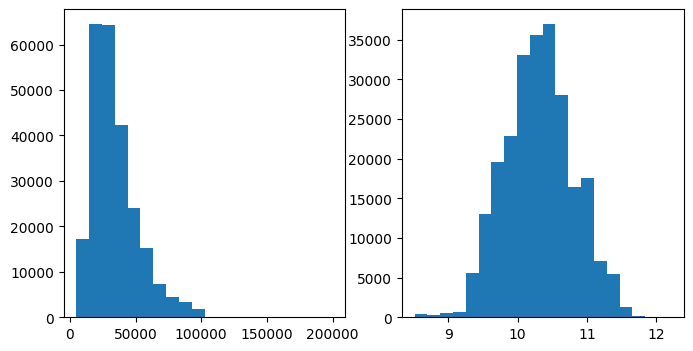

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
199553,71851249,CPCS Roller Driver,We urgently require CPCS Roller Drivers to wor...,Southminster Essex South East,UK,NaN,contract,Gold Group Ltd.,Trade & Construction Jobs,10 - 11 per hour,20160,totaljobs.com,9.911506
204535,72033578,Guaranteed Primary Teacher workEaling and Brent,Guaranteed Primary Teacher Work Ealing & Bren...,Central London,Central London,full_time,contract,ITN Mark Education West London,Teaching Jobs,30000.00 - 42500.00 GBP Annual,36250,jobs.newstatesman.com,10.498222
78002,69013272,Warehouse Manager,An excellent opportunity has become available ...,"Bromsgrove, Hereford Worcestershire",UK,NaN,contract,Adecco,Other/General Jobs,16000 - 17000/annum,16500,cv-library.co.uk,9.711176


In [6]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()


def _tokenize(text:str) -> str:
    text = str(text)
    return ' '.join(tokenizer.tokenize(text)).lower()

In [7]:
data["Title"] = data["Title"].apply(_tokenize)
data["FullDescription"] = data["FullDescription"].apply(_tokenize)

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


In [9]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for title in data['Title']:
    for token in title.split():
        token_counts[token] += 1 
        
for title in data['FullDescription']:
    for token in title.split():
        token_counts[token] += 1 


In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [12]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [13]:
token_to_id = {}

for i, token in enumerate(tokens):
    token_to_id[token] = i

In [14]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


In [15]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [16]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


In [17]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [20]:
make_batch(data_train[:1], max_len=10)

{'Title': tensor([[27645, 29893, 33674]], device='cuda:0'),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([9.7115], device='cuda:0')}

In [21]:
b = make_batch(data_train, max_len=30)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(num_embeddings=len(tokens), embedding_dim=32)
        self.conv = torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3,)
        
    def forward(self, idx):
        embs = self.emb(idx)
        emb_transposed = torch.einsum('ijk->ikj', embs)
        convs_outs = self.conv(emb_transposed)
        max_pool = torch.max(convs_outs, dim=-1).values
        return max_pool
    

class SalaryPredictionModel(nn.Module):
    def __init__(self,
                 n_tokens=len(tokens), 
                 n_cat_features=len(categorical_vectorizer.vocabulary_), 
                 hid_size=64):
        super(SalaryPredictionModel, self).__init__()
        
        # Эмбеддинг слой для текстовых данных
        self.emb = TextEncoder()

        # Полносвязный слой для категориальных данных
        self.fc_categ = nn.Linear(n_cat_features, hid_size)

        # Объединение выходов
        self.fc_combined = nn.Linear(3 * hid_size, 2 * hid_size)
        
        # Выходной слой
        self.fc_out = nn.Linear(2 * hid_size, 1)
        self.dropout = nn.Dropout(0.15)

    def forward(self, title, descr, categ):
        # Применение эмбеддинга и свертки к заголовку
        title_out = self.emb(title)

        # Применение эмбеддинга и свертки к описанию
        descr_out = self.emb(descr)

        # Применение полносвязного слоя к категориальным данным
        categ_out = F.relu(self.fc_categ(categ))

        # Объединение выходов
        combined = torch.cat([title_out, descr_out, categ_out], dim=1)
        combined = F.relu(self.fc_combined(combined))

        # Выходной слой
        out = self.fc_out(self.dropout(combined))
        return out

In [23]:
from torch.utils.data import Dataset, DataLoader

class SalaryDataset(Dataset):
    def __init__(self, titles, descriptions, categorical, salaries):
        self.titles = titles
        self.descriptions = descriptions
        self.categorical = categorical
        self.salaries = salaries

    def __len__(self):
        return len(self.salaries)

    def __getitem__(self, idx):
        return {
            "Title": self.titles[idx],
            "FullDescription": self.descriptions[idx],
            "Categorical": self.categorical[idx],
            "Log1pSalary": self.salaries[idx]
        }
    
    
    

# Создание экземпляра Dataset
dataset = SalaryDataset(b['Title'], b['FullDescription'], b['Categorical'], b['Log1pSalary'])

# Создание DataLoader
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)


In [24]:
model = SalaryPredictionModel()
model = model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

In [25]:
torch.cuda.empty_cache()

In [27]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(dataloader):
        titles = batch['Title'].to(device)
        descriptions = batch['FullDescription'].to(device)
        categorical = batch['Categorical'].to(device)
        salaries = batch['Log1pSalary'].to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямое распространение
        outputs = model(titles, descriptions, categorical)

        # Расчет потерь
        loss = criterion(outputs, salaries.unsqueeze(1))

        # Обратное распространение и оптимизация
        loss.backward()

#         # Проверка и вывод градиентов (каждые 1000 итераций)
#         if i % 5000 == 0:
#             for name, param in model.emb.named_parameters():
#                 if param.grad is not None:
#                     print(f"Gradient for {name}: {param.grad.norm()}")
#                     print()
#                 else:
#                     print('------------------------')
#                     print(f"NO gradient for {name}")
#                     print('========================')

        optimizer.step()

        total_loss += loss.item()
        if i % 1000 == 0:
            print(f'Average loss after {i} batches: {total_loss / (i + 1):.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')


Average loss after 0 batches: 0.4074
Average loss after 1000 batches: 0.4248
Average loss after 2000 batches: 0.4240
Average loss after 3000 batches: 0.4227
Average loss after 4000 batches: 0.4210
Average loss after 5000 batches: 0.4179
Average loss after 6000 batches: 0.4154
Average loss after 7000 batches: 0.4122
Average loss after 8000 batches: 0.4095
Average loss after 9000 batches: 0.4067
Epoch [1/3], Loss: 0.4045
Average loss after 0 batches: 0.3816
Average loss after 1000 batches: 0.3742
Average loss after 2000 batches: 0.3734
Average loss after 3000 batches: 0.3713
Average loss after 4000 batches: 0.3691
Average loss after 5000 batches: 0.3667
Average loss after 6000 batches: 0.3648
Average loss after 7000 batches: 0.3628
Average loss after 8000 batches: 0.3607
Average loss after 9000 batches: 0.3585
Epoch [2/3], Loss: 0.3565
Average loss after 0 batches: 0.2891
Average loss after 1000 batches: 0.3331
Average loss after 2000 batches: 0.3285
Average loss after 3000 batches: 0.32

In [29]:
test = make_batch(data_val)

In [30]:
single_title = test['Title'][0].unsqueeze(0)  # Добавляем размерность батча
single_description = test['FullDescription'][0].unsqueeze(0)
single_categorical = test['Categorical'][0].unsqueeze(0)

model.eval()
with torch.no_grad():
    single_prediction = model(single_title, single_description, single_categorical)

print(single_prediction)

tensor([[10.6454]], device='cuda:0')


In [31]:
title = test['Title'][0].unsqueeze(0) 
descr = test['FullDescription'][0].unsqueeze(0)
categ = test['Categorical'][0].unsqueeze(0)


# Предполагаем, что у вас есть данные: titles, descriptions, categorical
titles = titles.to(device)  # Перенос на GPU, если используется
descriptions = descriptions.to(device)
categorical = categorical.to(device)

model.eval()  # Переключение модели в режим оценки
with torch.no_grad():
    predictions = model(title, descr, categ)
    print(predictions)
# Преобразование предсказаний, если это необходимо
# Например, если вы использовали log1p для метки, примените expm1
predicted_salaries = torch.expm1(predictions).to('cpu').numpy()
predicted_salaries

tensor([[10.6454]], device='cuda:0')


array([[41995.875]], dtype=float32)

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!